In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import pickle
import shap

In [ ]:
df = pd.read_csv(r'C:\Users\eliya\OneDrive\Desktop\Data Science Projects\DS_salary_estimator\salary_data_post_EDA.csv')

In [ ]:
#Small data cleaning
df = df.rename(columns={'aws_yn': 'aws',
                        'excel_yn': 'excel',
                        'tableau_yn': 'tableau',
                        'spark_yn': 'spark'})

In [ ]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'r_yn',
       'spark', 'aws', 'excel', 'tableau', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [ ]:
#Choose relevant columns
df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_comp','hourly','employer_provided',
             'job_state','same_state','age','python_yn','spark','aws','excel','job_simp','seniority','desc_len']]
df_model.head()


,avg_salary,Rating,Size,Type of ownership,Industry,Sector,Revenue,num_comp,hourly,employer_provided,job_state,same_state,age,python_yn,spark,aws,excel,job_simp,seniority,desc_len
0,72.0,3.8,501 to 1000 employees,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),0,0,0,NM,0,50,1,0,0,1,data scientist,na,2536
1,87.5,3.4,10000+ employees,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),0,0,0,MD,0,39,1,0,0,0,data scientist,na,4783
2,85.0,4.8,501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),0,0,0,FL,1,13,1,1,0,1,data scientist,na,3461
3,76.5,3.8,1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),3,0,0,WA,1,58,1,0,0,0,data scientist,na,3883
4,114.5,2.9,51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,3,0,0,NY,1,25,1,0,0,1,data scientist,na,2728


In [ ]:
#train test split
X = df_model.drop('avg_salary', axis = 1)
y = df_model.avg_salary.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#OneHotEncoder for the train data, than the test data
# fit and transform on training data
encoder = OneHotEncoder(handle_unknown='ignore')  # handle_unknown='ignore' to handle categories in validation data that didn't exist in training data
X_train_encoded = encoder.fit_transform(X_train)
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(X_train.columns))

# all data
X_encoded = encoder.transform(X)
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(X_train.columns))

# transform on testing data
X_test_encoded = encoder.transform(X_test)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(X_train.columns))

In [ ]:
#Cheacking weights of each feature to see which one is more important (and validate there's no zero weight)
X_train_encoded_df.mean(axis=0).sort_values(ascending=False)

employer_provided_0    0.978078
hourly_0               0.964587
spark_0                0.775717
aws_0                  0.757167
seniority_na           0.701518
                         ...   
desc_len_3478          0.001686
desc_len_1629          0.001686
desc_len_3461          0.001686
desc_len_1632          0.001686
desc_len_2011          0.001686
Length: 707, dtype: float64

In [ ]:
# Normalizing the train data
scaler = StandardScaler()
scaler.fit(X_train_encoded_df)
X_train = scaler.transform(X_train_encoded_df)
X_test = scaler.transform(X_test_encoded_df)
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,...,697,698,699,700,701,702,703,704,705,706
0,-0.109295,-0.058173,-0.082409,-0.058173,-0.058173,-0.101101,-0.058173,-0.130968,-0.130968,-0.092214,...,-0.071307,-0.058173,-0.0411,-0.058173,-0.0411,-0.0411,-0.058173,-0.0411,-0.0411,-0.058173
1,-0.109295,-0.058173,-0.082409,-0.058173,-0.058173,-0.101101,-0.058173,-0.130968,-0.130968,-0.092214,...,-0.071307,-0.058173,-0.0411,-0.058173,-0.0411,-0.0411,-0.058173,-0.0411,-0.0411,-0.058173
2,-0.109295,-0.058173,-0.082409,-0.058173,-0.058173,-0.101101,-0.058173,-0.130968,-0.130968,-0.092214,...,-0.071307,-0.058173,-0.0411,-0.058173,-0.0411,-0.0411,-0.058173,-0.0411,-0.0411,-0.058173
3,-0.109295,-0.058173,-0.082409,-0.058173,-0.058173,-0.101101,-0.058173,-0.130968,-0.130968,-0.092214,...,-0.071307,-0.058173,-0.0411,-0.058173,-0.0411,-0.0411,-0.058173,-0.0411,-0.0411,-0.058173
4,-0.109295,-0.058173,-0.082409,-0.058173,-0.058173,-0.101101,-0.058173,-0.130968,-0.130968,-0.092214,...,-0.071307,-0.058173,-0.0411,-0.058173,-0.0411,-0.0411,-0.058173,-0.0411,-0.0411,-0.058173


## time to evaluate the models MAE to determine which model is best for the Salary Estimator:

In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 8.397114447830582


In [ ]:
# Create an instance of RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42, max_features= 10)

# Fit the model on your training data
model.fit(X_train, y_train)

# Now that the model is trained, you can use it to make predictions or evaluate its accuracy.
predictions = model.predict(X_test)

# Compute accuracy or some other performance metric
from sklearn.metrics import mean_squared_error
accuracy = mean_squared_error(y_test, predictions)
MAE_rf = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error for RandomForestRegressor:", MAE_rf)

Mean Absolute Error for RandomForestRegressor: 12.956107382550334


In [ ]:
# Multiple linear regression 
X = sm.add_constant(X_encoded_df)
X_sm = X
model = sm.OLS(y,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.048e+28
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:29:38   Log-Likelihood:                 20364.
No. Observations:                 742   AIC:                        -3.979e+04
Df Residuals:                     275   BIC:                        -3.764e+04
Df Model:                         466                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                17.8846   1.02e-13   1.75e+14      0.000      17.885      17.885
Rating_-1.0                                          -2.9417   3.47e-13  -8.49e+12      0.000      -2.942      -2.942
Rating_1.9                                            1.7811   4.37e-13   4.07e+12      0.000       1.781       1.781
Rating_2.1                                            6.8482   2.77e-13   2.47e+13      0.000       6.848       6.848
Rating_2.2                                          -11.2681   3.84e-13  -2.93e+13      0.000     -11.268     -11.268
Rating_2.3                                            8.5578   2.84e-13   3.01e+13      0.000       8.558       8.558
Rating_2.4                                          -25.5856   3.28e-13   -7.8e+13      0.000     -25.586     -25.586
Rating_2.5                                            0.4048   2.56e-13   1.58e+12      0.000       0.405       0.405
Rating_2.6                                           -5.4172   2.88e-13  -1.88e+13      0.000      -5.417      -5.417
Rating_2.7                                           12.2112   2.79e-13   4.38e+13      0.000      12.211      12.211
Rating_2.8                                           -4.2281   2.58e-13  -1.64e+13      0.000      -4.228      -4.228
Rating_2.9                                          -12.6314   2.79e-13  -4.53e+13      0.000     -12.631     -12.631
Rating_3.0                                          -15.9364   4.29e-13  -3.72e+13      0.000     -15.936     -15.936
Rating_3.1                                          -12.3443   2.33e-13   -5.3e+13      0.000     -12.344     -12.344
Rating_3.2                                            9.2496   1.59e-13   5.83e+13      0.000       9.250       9.250
Rating_3.3                                           -5.4160   2.52e-13  -2.15e+13      0.000      -5.416      -5.416
Rating_3.4                                            1.7529   2.28e-13   7.68e+12      0.000       1.753       1.753
Rating_3.5                                           -6.1119   2.37e-13  -2.57e+13      0.000      -6.112      -6.112
Rating_3.6                                           -5.3428   1.73e-13  -3.09e+13      0.000      -5.343      -5.343
Rating_3.7                                            6.5748   1.52e-13   4.32e+13      0.000       6.575       6.575
Rating_3.8                                           19.7178   1.69e-13   1.17e+14      0.000      19.718      19.718
Rating_3.9                                           -7.2286   1.81e-13  -3.99e+13      0.000      -7.229      -7.229
Rating_4.0                                            1.7847    2.6e-13   6.86e+12      0.000       1.785       1.785
Rating_4.1     

In [ ]:
# Linear Regression Model
lm = LinearRegression()
lm.fit(X_train, y_train)
MAE_lm = np.mean(cross_val_score(lm,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 20))
print("Man Absolute Error for Linear Regression Model:", MAE_lm)

Man Absolute Error for Linear Regression Model: -11.71900069155816


In [ ]:
import warnings
warnings.filterwarnings('always')

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.364e+02, tolerance: 8.737e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e+02, tolerance: 6.059e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.387e+02, tolerance: 5.683e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e+02, tolerance: 5.722e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e+02, tolerance: 6.059e+01
Objective did n

,alpha,error
0,0.01,-12.387323


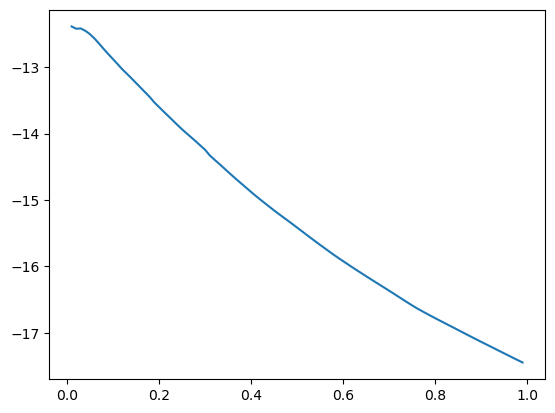

In [ ]:
# lasso regression 
lm_l = Lasso(alpha=.01)
lm_l.fit(X_train,y_train)
np.mean(cross_val_score(lm_l, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 3))

alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))
    
plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]


In [ ]:
# Random Forest 
rf = RandomForestRegressor()
np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 10))

-13.078712853107342

In [ ]:
# Create an XGBoost model
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 100)

# Fit the model
model.fit(X_train_encoded_df, y_train)

# Predict the target on the test dataset
predict_test = model.predict(X_test_encoded_df)

# You can also evaluate the performance of the model
from sklearn.metrics import mean_squared_error
mae_XGB = mean_absolute_error(y_test, predict_test)
print("Mean Absolute Error for XGBoost model: ",mae_XGB)

Mean Absolute Error for XGBoost model:  10.930336881803987


### Let's do some Feature Extraction 

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train_encoded_df,y_train)
preds = xg_reg.predict(X_test_encoded_df)
explainer = shap.TreeExplainer(xg_reg) #Works also with random forest, lightGBM, DecisionTreeClassifer/Regressor. 
explanation = explainer(X_test_encoded_df)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vm

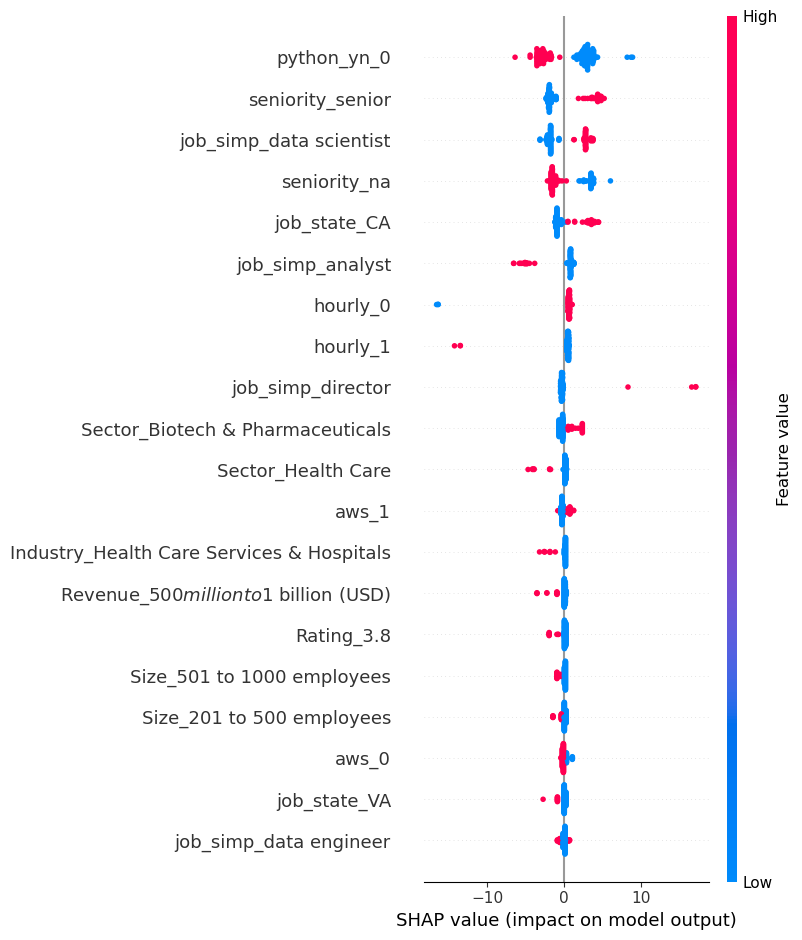

In [ ]:
explainer = shap.TreeExplainer(xg_reg) #Works also with random forest, lightGBM, DecisionTreeClassifer/Regressor. 
explanation = explainer(X_test_encoded_df)
shap.summary_plot(explanation)

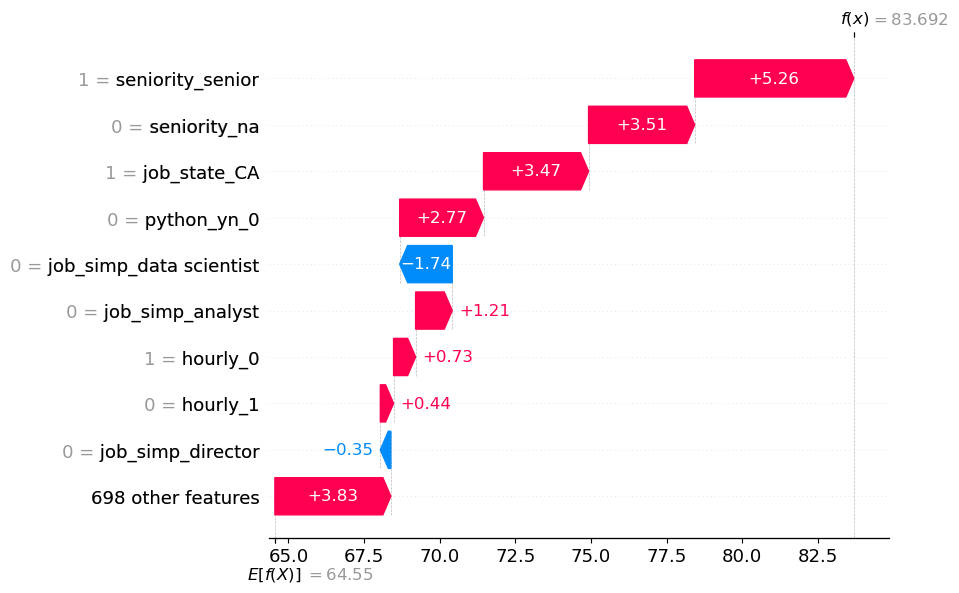

In [ ]:
#2. Waterfall plot
shap.plots.waterfall(explanation[4])

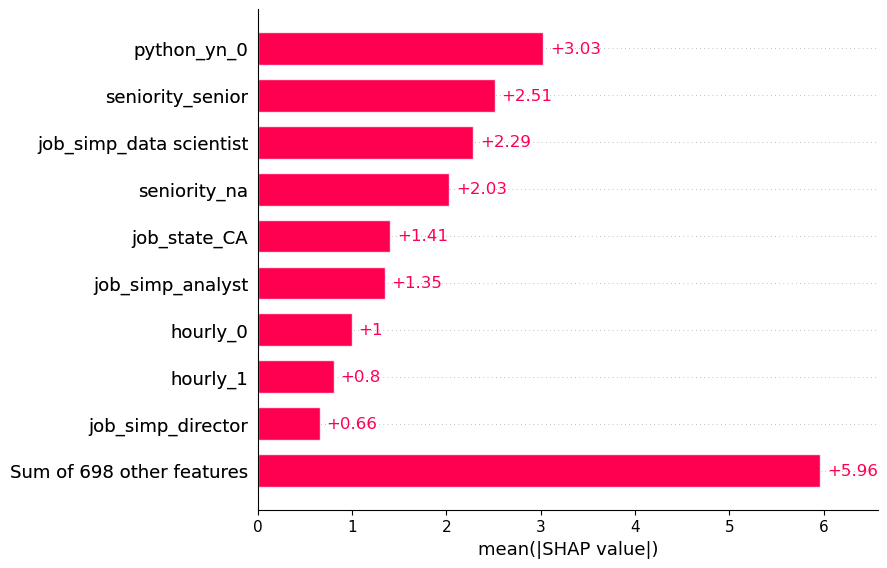

In [ ]:
shap.plots.bar(explanation)

In [ ]:
def shuffle_one_feature(df, feature_name):
    df_shuffled = df_model.copy()
    original_data = df_shuffled[feature_name] #the original values of the feature
    shuffled_data = np.random.permutation(original_data) #shuffled data
    df_shuffled[feature_name] = shuffled_data #overwrite the original data with the shuffled
    return df_shuffled

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_encoded_df, y_train)
y_pred = rf.predict(X_test_encoded_df)
t = mean_squared_error(y_test, y_pred)

In [ ]:
feature_importances = {}
X_test_new = pd.DataFrame(X_test_encoded_df, columns = pd.DataFrame(X_train_encoded_df).columns)

for feature_name in X_test_new.columns:
    importances = []
    for i in range(10):
        X_shuffled = shuffle_one_feature(X_test_new, feature_name)
        y_pred_shuffled = rf.predict(X_shuffled)
        t1 = mean_squared_error(y_test, y_pred_shuffled)
        importances.append(t1-t)

    feature_importances[feature_name] = importances
feature_importances_df = pd.DataFrame(feature_importances)
feature_importances_df.mean().sort_values(ascending = False)

In [ ]:
X_test_new = pd.DataFrame(X_test_encoded_df, columns = pd.DataFrame(X_train_encoded_df).columns)
# X_shuffled = shuffle_one_feature(X_test_new, "Rating_1.0")
# X_shuffled = shuffle_one_feature(X_shuffled, "Rating_1.0")
# X_shuffled = shuffle_one_feature(X_shuffled, "Rating_1.0") 
X_train_encoded_df.columns

Index(['Rating_-1.0', 'Rating_1.9', 'Rating_2.1', 'Rating_2.2', 'Rating_2.3',
       'Rating_2.4', 'Rating_2.5', 'Rating_2.6', 'Rating_2.7', 'Rating_2.8',
       ...
       'desc_len_7361', 'desc_len_7383', 'desc_len_7548', 'desc_len_7802',
       'desc_len_8175', 'desc_len_8397', 'desc_len_8734', 'desc_len_8761',
       'desc_len_9120', 'desc_len_10051'],
      dtype='object', length=707)

In [ ]:
# tune models GridsearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Create a model
model = RandomForestRegressor()

# Create a dictionary of hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],  # number of trees
    'max_depth': [None, 10, 20, 30],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # minimum number of samples required to split a node
}

# Setup the grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error') 


# Fit the grid search to the data
grid_search.fit(X_encoded_df, y)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

print("Best parameters: ", best_params)
print("Best model: ", best_model)

Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best model:  RandomForestRegressor()


In [ ]:
# test ensembles
parameters = {'n_estimators':range(10,300,10), 'criterion':('mse','mae'), 'max_features':('auto','sqrt','log2')} 
gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train, y_train)
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,tpred_lm)
mean_absolute_error(y_test,tpred_lml)
mean_absolute_error(y_test,tpred_rf)

mean_absolute_error(y_test,(tpred_lm+tpred_rf)/2)

import pickle
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

model.predict(np.array(list(X_test.iloc[1,:])).reshape(1,-1))[0]

list(X_test.iloc[1,:])

### For conclusion:
### 1. **Linear Regression** is the best model (the lowest MAE) for this dataset - 8.4.
### 2. My second best models is **lasso regression** and Random Forest.

### as to Feature Importance:
1. our predictions were affected the most by `Seniority`
2. Our second is `Python yn` or the feature says - does Python specified in the job description?